In [2]:
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('Radioactivity in the ground at 2 hourly intervals over one year July 2.csv', index_col=0, names=['x'], skiprows=1)
df['t'] = pd.date_range('02/07/2000', periods=len(df.index.values), freq='2H')
df

,x,t
1,0.099992,2000-02-07 00:00:00
2,0.099169,2000-02-07 02:00:00
3,0.103160,2000-02-07 04:00:00
4,0.106554,2000-02-07 06:00:00
5,0.101224,2000-02-07 08:00:00
...,...,...
4366,0.107107,2001-02-04 18:00:00
4367,0.106559,2001-02-04 20:00:00
4368,0.105592,2001-02-04 22:00:00
4369,0.105697,2001-02-05 00:00:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4370 entries, 1 to 4370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   x       4370 non-null   float64       
 1   t       4370 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 102.4 KB


Text(0, 0.5, 'Dose rate')

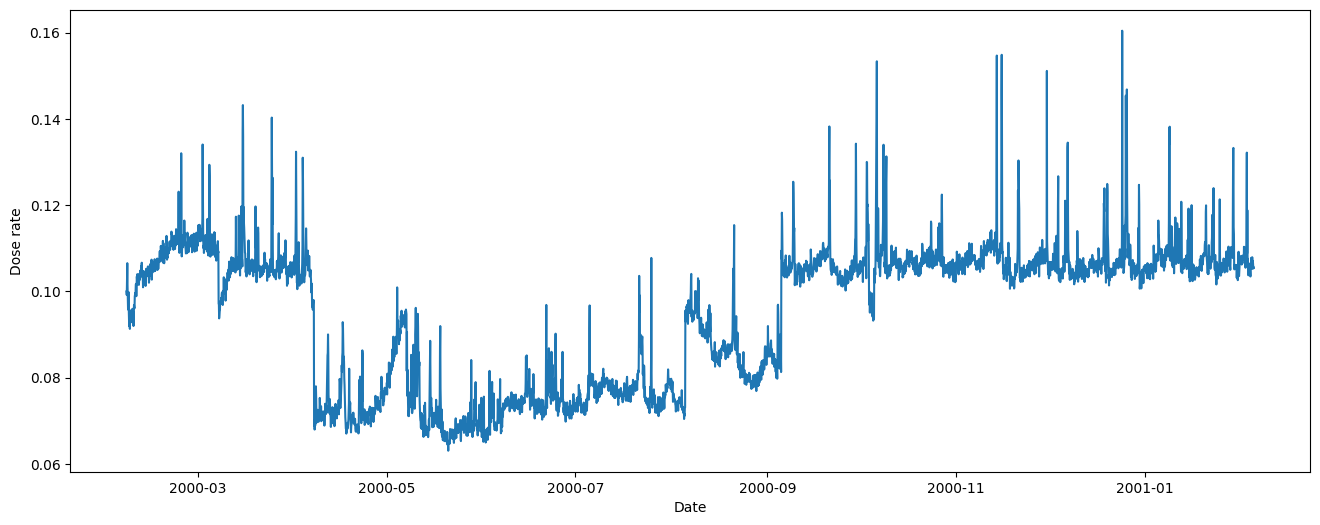

In [5]:
plt.figure(figsize=(16, 6))

plt.plot(df.t, df.x)
plt.xlabel("Date")
plt.ylabel("Dose rate")

In [6]:
def data_split(ts, param, train_percentage):
    timeseries = ts[param].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [7]:
import torch
 
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [27]:
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [23]:
train, test, total = data_split(df, "x", 0.8)
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [28]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=16)

EPOCHS = 50

In [20]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs):
    y_pred_train = None
    y_pred_test = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 2 != 0:
            continue
        model.eval()
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred_train = y_pred
            train_rmse = np.sqrt(loss_fn(y_pred, y_train))
            y_pred = model(X_test)
            y_pred_test = y_pred
            test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    return y_pred_train, y_pred_test, model

In [29]:
y_pred_train, y_pred_test, model = train_model(model, X_train, X_test, y_train, y_test, EPOCHS)

Epoch 0: train RMSE 0.0170, test RMSE 0.0143
Epoch 2: train RMSE 0.0168, test RMSE 0.0197
Epoch 4: train RMSE 0.0166, test RMSE 0.0188
Epoch 6: train RMSE 0.0165, test RMSE 0.0150
Epoch 8: train RMSE 0.0163, test RMSE 0.0160
Epoch 10: train RMSE 0.0162, test RMSE 0.0151
Epoch 12: train RMSE 0.0161, test RMSE 0.0143
Epoch 14: train RMSE 0.0157, test RMSE 0.0156
Epoch 16: train RMSE 0.0154, test RMSE 0.0150
Epoch 18: train RMSE 0.0152, test RMSE 0.0128
Epoch 20: train RMSE 0.0145, test RMSE 0.0126
Epoch 22: train RMSE 0.0137, test RMSE 0.0114
Epoch 24: train RMSE 0.0121, test RMSE 0.0118
Epoch 26: train RMSE 0.0106, test RMSE 0.0130
Epoch 28: train RMSE 0.0087, test RMSE 0.0117
Epoch 30: train RMSE 0.0102, test RMSE 0.0058
Epoch 32: train RMSE 0.0070, test RMSE 0.0097
Epoch 34: train RMSE 0.0040, test RMSE 0.0051
Epoch 36: train RMSE 0.0038, test RMSE 0.0050
Epoch 38: train RMSE 0.0049, test RMSE 0.0056
Epoch 40: train RMSE 0.0042, test RMSE 0.0052
Epoch 42: train RMSE 0.0042, test RMSE 

In [13]:
torch.save(model, f"./lstm_forecast_{EPOCHS}_epochs.pth")

In [14]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    true = pd.DataFrame(true.flatten().numpy())[0]
    pred = pd.DataFrame(pred.flatten().numpy())[0]
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", np.sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [15]:
def plot_train_n_pred(X_train, X_test, total, model):
    with torch.no_grad():
    # shift train predictions for plotting
        train_plot = np.ones_like(total) * np.nan
        y_pred = model(X_train)
        y_pred = y_pred[:, -1]
        train_size = len(X_train)
        train_plot[lookback:train_size + 1] = model(X_train)[:, -1]
        # shift test predictions for plotting
        test_plot = np.ones_like(total) * np.nan
        test_plot[train_size + lookback:len(total) - 1] = model(X_test)[:, -1]

    plt.rcParams["figure.figsize"] = [12, 7]
    plt.plot(total, c='b')
    plt.plot(train_plot, c='r')
    plt.plot(test_plot, c='g')
    plt.show()

In [16]:
def validate_on_mesured(model):
    valid_train, valid_test, valid_total = data_split(df, "x", 0.8)
    
    lookback = 1
    X_train, _ = create_dataset(valid_train, lookback=lookback)
    X_test, y_test = create_dataset(valid_test, lookback=lookback)

    y_pred = model(X_test)
    y_pred_test = y_pred
    
    try:
        validate(y_pred_test, y_test)
    except:
        validate(y_pred_test.detach(), y_test.detach())
    plot_train_n_pred(X_train, X_test, valid_total, model)

MSE: 2.6634132e-05
RMSE: 0.0051608267
MAE: 0.00287739
MAPE: 2.6313725858926773
R2: 0.12675178029382017


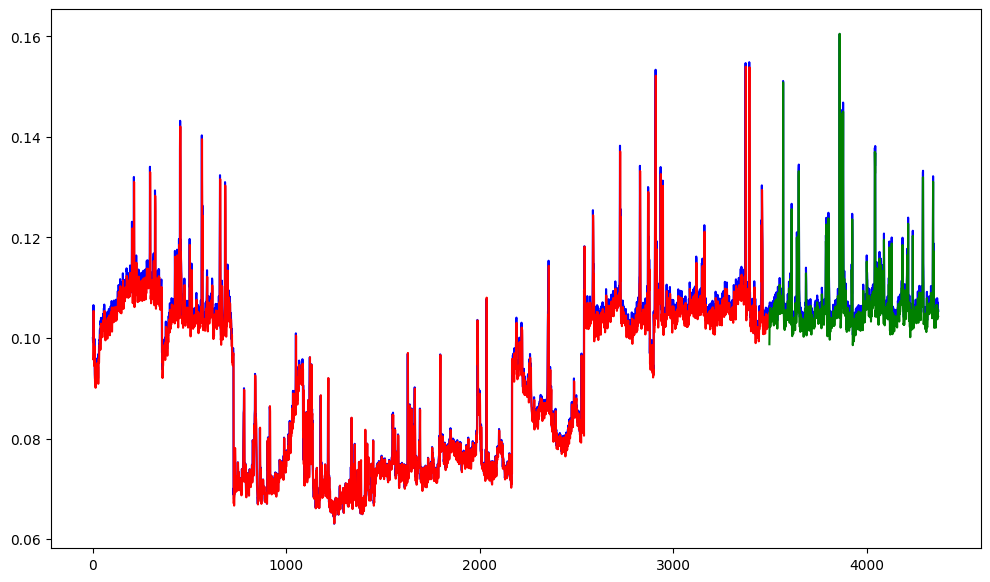

In [30]:
validate_on_mesured(model)